INFO:root:267468 utilisateurs chargés.



--- Rapport de classification ---
              precision    recall  f1-score   support

           0     0.9989    0.9995    0.9992     79438
           1     0.9498    0.8954    0.9218       803

    accuracy                         0.9985     80241
   macro avg     0.9744    0.9475    0.9605     80241
weighted avg     0.9985    0.9985    0.9985     80241


--- Matrice de confusion ---
[[79400    38]
 [   84   719]]


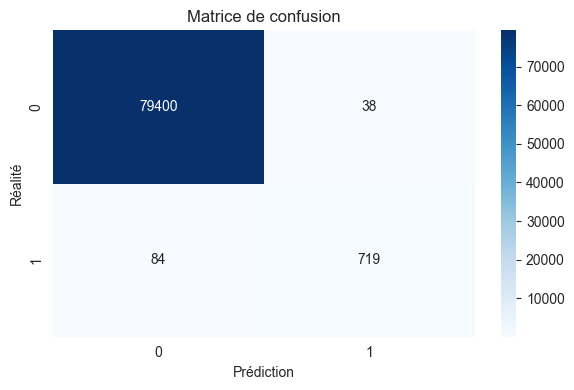

C:\Users\MSI\AppData\Local\Temp\ipykernel_16884\1284854465.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="coolwarm")


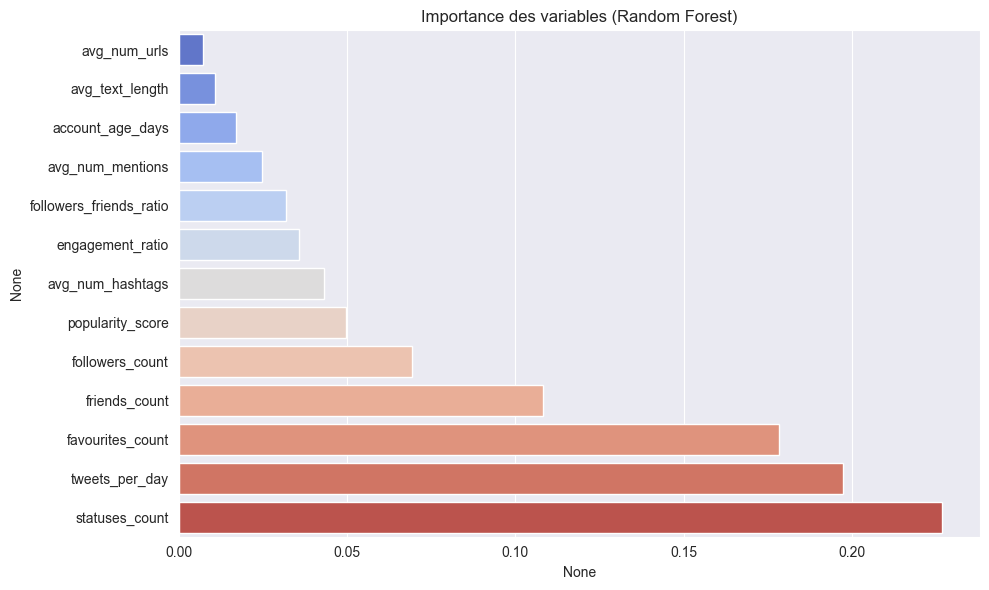

INFO:root:0 documents insérés ou mis à jour dans 'users_labeled_outliers_supervised'.



--- Top 10 profils les plus atypiques ---
                             _id  atypicality_score  followers_count  \
138460  6845c00477a64f3b4a0798d5         903.814111         13116345   
190038  6845c00477a64f3b4a08624f         371.839166         30755372   
41774   6845c00377a64f3b4a061f27         300.559990          7136560   
35161   6845c00377a64f3b4a060552         299.744979         29274484   
10530   6845c00177a64f3b4a05a51b         288.038458            54375   
258092  6845c00777a64f3b4a096c25         284.610418            14236   
124824  6845c00477a64f3b4a076391         284.461715          2546923   
62535   6845c00477a64f3b4a067040         240.243702            72020   
7136    6845c00177a64f3b4a0597d9         217.413482         23537513   
230984  6845c00777a64f3b4a090241         191.752968          3673590   

        friends_count  tweets_per_day  avg_num_hashtags  avg_text_length  
138460              2       23.558737          3.000000       127.000000  
190038        

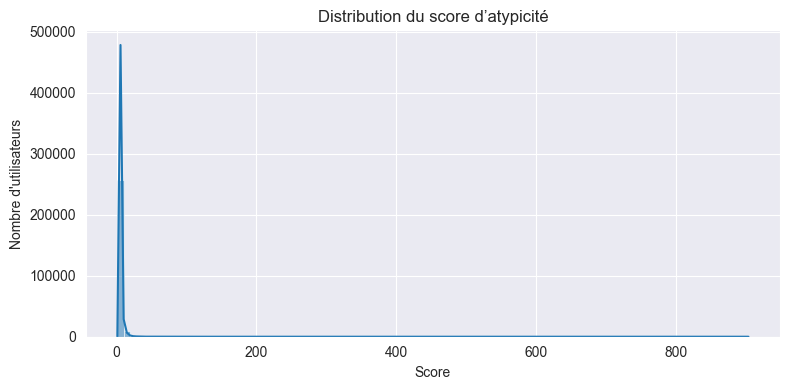

INFO:root:Pipeline terminé avec succès.


In [3]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pymongo import MongoClient
from pymongo.errors import BulkWriteError

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# === Étape 1 : Connexion MongoDB et chargement des données ===
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

users_df = pd.DataFrame(list(db["user_db"].find()))
logging.basicConfig(level=logging.INFO)
logging.info(f"{len(users_df)} utilisateurs chargés.")

# === Étape 2 : Préparation des variables ===
variables = [
    "tweets_per_day", "friends_count", "followers_count", "followers_friends_ratio",
    "favourites_count", "statuses_count", "avg_text_length", "popularity_score",
    "avg_num_hashtags", "avg_num_mentions", "avg_num_urls", "account_age_days",
    "engagement_ratio"
]

users_df.dropna(subset=variables, inplace=True)
X = users_df[variables].fillna(0)

# === Étape 3 : Calcul du score d’atypicité ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
z_scores = np.abs(X_scaled)
users_df["atypicality_score"] = z_scores.sum(axis=1)

# Seuil : top 1% les plus atypiques
threshold = users_df["atypicality_score"].quantile(0.99)
users_df["is_outlier"] = (users_df["atypicality_score"] > threshold).astype(int)

# === Étape 4 : Entraînement du modèle ===
y = users_df["is_outlier"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === Étape 5 : Évaluation ===
print("\n--- Rapport de classification ---")
print(classification_report(y_test, y_pred, digits=4))

print("\n--- Matrice de confusion ---")
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.tight_layout()
plt.savefig("images/confusion_matrix_supervised.png")
plt.show()

# === Étape 6 : Importance des variables ===
importances = pd.Series(model.feature_importances_, index=variables).sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette="coolwarm")
plt.title("Importance des variables (Random Forest)")
plt.tight_layout()
plt.savefig("images/feature_importance_supervised.png")
plt.show()

# === Étape 7 : Prédictions finales et sauvegarde ===
users_df["predicted_outlier"] = model.predict(X)

collection_name = "users_labeled_outliers_supervised"
collection = db[collection_name]
n_inserted = 0
for doc in users_df.to_dict("records"):
    result = collection.update_one(
        {"_id": doc["_id"]},
        {"$set": doc},
        upsert=True
    )
    if result.upserted_id:
        n_inserted += 1

logging.info(f"{n_inserted} documents insérés ou mis à jour dans '{collection_name}'.")

# === Étape 8 : Top profils atypiques ===
top_atypiques = users_df.sort_values("atypicality_score", ascending=False).head(10)
print("\n--- Top 10 profils les plus atypiques ---")
print(top_atypiques[[
    "_id", "atypicality_score", "followers_count", "friends_count",
    "tweets_per_day", "avg_num_hashtags", "avg_text_length"
]])

plt.figure(figsize=(8, 4))
sns.histplot(users_df["atypicality_score"], bins=100, kde=True)
plt.title("Distribution du score d’atypicité")
plt.xlabel("Score")
plt.ylabel("Nombre d'utilisateurs")
plt.tight_layout()
plt.savefig("images/atypicality_distribution.png")
plt.show()

client.close()
logging.info("Pipeline terminé avec succès.")


In [4]:
from pymongo import MongoClient
import pandas as pd

# Connexion
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

# Chargement des outliers détectés par Random Forest
users_df = pd.DataFrame(list(db["users_labeled_outliers_supervised"].find()))

# Chargement des métadonnées utilisateurs Twitter
twitter_users_df = pd.DataFrame(list(db["twitter_users"].find()))

# Vérifier les types et convertir les `id` si nécessaire
twitter_users_df["id"] = pd.to_numeric(twitter_users_df["id"], errors="coerce")
users_df["id"] = pd.to_numeric(users_df["id"], errors="coerce")

# Top 10 par score d’atypicité
top_outliers = users_df.sort_values("atypicality_score", ascending=False).head(10)

# Fusion propre sur l'identifiant Twitter (id)
merged_df = pd.merge(
    top_outliers,
    twitter_users_df[["id", "screen_name", "verified", "description"]],
    on="id",
    how="left"
)

# Sélection et affichage
result_df = merged_df[[
    "screen_name", "verified", "description",
    "followers_count", "friends_count", "tweets_per_day", "atypicality_score"
]]

pd.set_option("display.max_colwidth", 150)
print("\n Profils les plus atypiques enrichis :\n")
print(result_df.to_string(index=False))


 Profils les plus atypiques enrichis :

 screen_name  verified                                                                                                                                                     description  followers_count  friends_count  tweets_per_day  atypicality_score
     sabqorg      True الحساب الرسمي لصحيفة سبق الإلكترونية، Sabq Apps: http://land.ly/sabq - للإعلان في شبكات التواصل trend@sabq.org - سناب شات https://www.snapchat.com/add/sabq_org         13116345              2       23.558737         903.814111
  realmadrid      True                                 ⚽️ Cuenta oficial del Real Madrid C.F. 🏆@realmadriden: 🇬🇧. @realmadridarab: العربيه.  @realmadridfra: 🇫🇷. @realmadridjapan: 🇯🇵.         30755372             54       10.029232         371.839166
  AjelNews24     False                الحساب الرسمي لـ خبر عاجل .. انستغرام: http://Instagram.com/ajelnews24 سناب شات: http://snapchat.com/add/ajelnews24 للتواصل: info@ajelnews24.com          7136560          